In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'SimHei'


# 从10年改成3年

In [3]:
from pvlib.iotools import get_pvgis_hourly

data, meta, inputs = get_pvgis_hourly(
    latitude=51.8830,
    longitude=4.4849,
    start=2020,
    end=2023,
    raddatabase='PVGIS-ERA5',
    surface_tilt=30,
    surface_azimuth=180,
    components=True,
    pvcalculation=True,
    peakpower=244.8,   # 1MW 装机容量
    pvtechchoice='crystSi',
    mountingplace='free',
    loss=14,          # 14% 损耗
    outputformat='json',
    map_variables=True
)

print(data.columns)

Index(['P', 'poa_direct', 'poa_sky_diffuse', 'poa_ground_diffuse',
       'solar_elevation', 'temp_air', 'wind_speed', 'Int'],
      dtype='object')


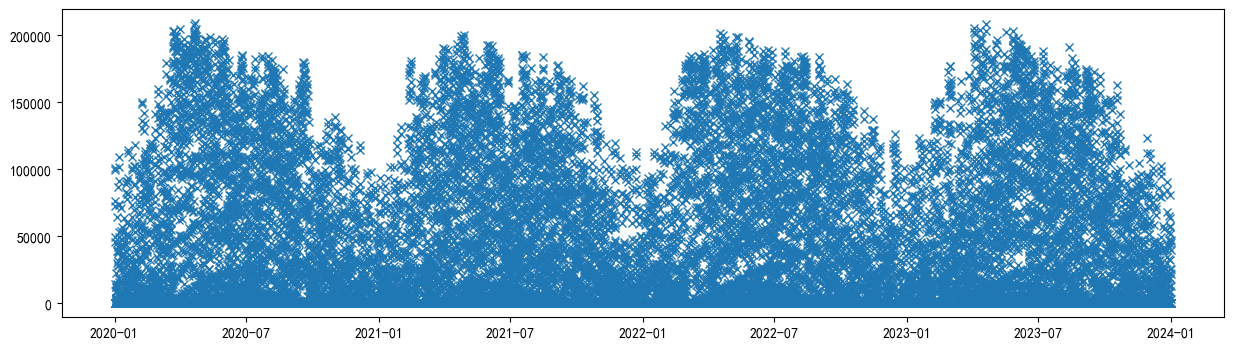

In [4]:
plt.figure(figsize=(15, 4))
plt.plot(data.index, data['P'],'x')
plt.show()

# 插值把1h间隔变成15min

In [6]:
import pandas as pd

# 假设你的原始DataFrame叫 df，索引为 datetime，1小时为频率
data = data.asfreq('1h')  # 明确索引频率

# 生成15分钟的时间索引
data_15min = data.resample('15min').interpolate(method='linear')  # 线性插值

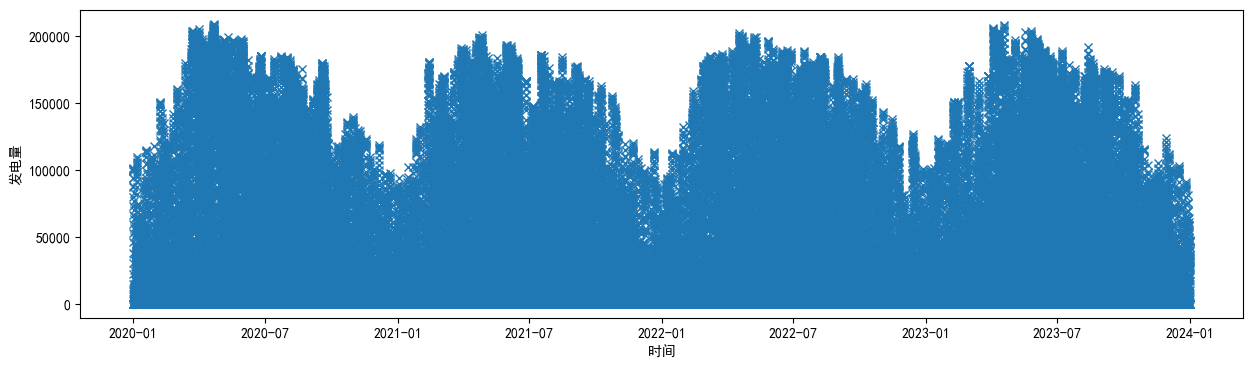

In [7]:
plt.figure(figsize=(15, 4))
plt.plot(data_15min.index, data_15min['P'],'x')
plt.xlabel("时间")
plt.ylabel("发电量")
plt.show()

## 训练集划分

In [9]:
data_15min

P  poa_direct  poa_sky_diffuse  \
time                                                          
2020-01-01 00:30:00+00:00  0.0         0.0              0.0   
2020-01-01 00:45:00+00:00  0.0         0.0              0.0   
2020-01-01 01:00:00+00:00  0.0         0.0              0.0   
2020-01-01 01:15:00+00:00  0.0         0.0              0.0   
2020-01-01 01:30:00+00:00  0.0         0.0              0.0   
...                        ...         ...              ...   
2023-12-31 22:30:00+00:00  0.0         0.0              0.0   
2023-12-31 22:45:00+00:00  0.0         0.0              0.0   
2023-12-31 23:00:00+00:00  0.0         0.0              0.0   
2023-12-31 23:15:00+00:00  0.0         0.0              0.0   
2023-12-31 23:30:00+00:00  0.0         0.0              0.0   

                           poa_ground_diffuse  solar_elevation  temp_air  \
time                                                                       
2020-01-01 00:30:00+00:00                 0.0              0.0     2.310   
2020-01-01 00:45:00+00:00                 0.0              0.0     2.250   
2020-01-01 01:00:00+00:00                 0.0              0.0     2.190   
2020-01-01 01:15:00+00:00                 0.0              0.0     2.130   
2020-01-01 01:30:00+00:00                 0.0              0.0     2.070   
...                                       ...              ...       ...   
2023-12-31 22:30:00+00:00                 0.0              0.0     8.290   
2023-12-31 22:45:00+00:00                 0.0              0.0     8.235   
2023-12-31 23:00:00+00:00                 0.0              0.0     8.180   
2023-12-31 23:15:00+00:00                 0.0              0.0     8.125   
2023-12-31 23:30:00+00:00                 0.0              0.0     8.070   

                           wind_speed  Int  
time                                        
2020-01-01 00:30:00+00:00       2.830  0.0  
2020-01-01 00:45:00+00:00       2.795  0.0  
2020-01-01 01:00:00+00:00       2.760  0.0  
2020-01-01 01:15:00+00:00       2.725  0.0  
2020-01-01 01:30:00+00:00       2.690  0.0  
...                               ...  ...  
2023-12-31 22:30:00+00:00       8.340  0.0  
2023-12-31 22:45:00+00:00       8.375  0.0  
2023-12-31 23:00:00+00:00       8.410  0.0  
2023-12-31 23:15:00+00:00       8.445  0.0  
2023-12-31 23:30:00+00:00       8.480  0.0  

[140253 rows x 8 columns]

In [10]:
import pandas as pd

# 假设 df 已经准备好
# df.index 是 datetime 索引，时区为 UTC，频率为 15min

def get_train_test_split(df, year=2023, months=[2, 5, 8, 11]):
    splits = {}

    for month in months:
        # 目标月的最后一天
        last_day = pd.Timestamp(f"{year}-{month:02d}-01", tz="UTC") + pd.offsets.MonthEnd(0)
        test_start = last_day - pd.Timedelta(days=6)
        test_end = last_day + pd.Timedelta(days=1)  # 包含最后一天24:00

        # 构造测试集 mask
        test_mask = (df.index >= test_start) & (df.index < test_end)
        test_df = df[test_mask]

        # 构造训练集 mask
        train_mask = ((df.index < test_start) & (df.index.year == year)) | (df.index.year < year)
        train_df = df[train_mask]

        splits[month] = {"train": train_df, "test": test_df}
        print(f"Month {month}: Train = {len(train_df)}, Test = {len(test_df)}")

    return splits

# 使用示例
splits = get_train_test_split(data_15min)

# 访问 2 月的训练集和测试集：
# train_feb = splits[2]["train"]
# test_feb = splits[2]["test"]


Month 2: Train = 110206, Test = 672
Month 5: Train = 119038, Test = 672
Month 8: Train = 127870, Test = 672
Month 11: Train = 136606, Test = 672


In [110]:
train_feb = splits[11]["train"]
test_feb = splits[11]["test"]

In [112]:
train_series = train_feb['P']  # 已经是一个 pd.Series，index是DatetimeIndex
test_series = test_feb['P'] 

## GBM

In [115]:
import numpy as np
import lightgbm as lgb
import pandas as pd

def create_lag_features(series, window=96):
    """
    根据历史功率series，构造特征和标签。
    特征是过去window个点功率，标签是下一个点功率。
    返回 X, y
    """
    X, y = [], []
    values = series.values
    for i in range(window, len(series)):
        X.append(values[i-window:i])
        y.append(values[i])
    return np.array(X), np.array(y)

# 1. 构造训练特征
window_size = 96  # 24小时历史
X_train, y_train = create_lag_features(train_series, window=window_size)

# 2. 训练LightGBM回归模型
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'seed': 42,
}
model = lgb.train(params, train_data, num_boost_round=100)

# 3. 滚动预测测试集（预测test_series长度）
# 测试时用train_series尾部最后window_size点作为初始输入
history = train_series.values[-window_size:].tolist()
predictions = []

for i in range(len(test_series)):
    x_input = np.array(history[-window_size:]).reshape(1, -1)
    y_pred = model.predict(x_input)[0]
    predictions.append(y_pred)
    # 滚动加入预测值
    history.append(y_pred)

# 4. 结果转换成Series方便对比
pred_series = pd.Series(predictions, index=test_series.index)

# 输出示例
print(pred_series.head())


time
2023-11-24 00:00:00+00:00    5.000246
2023-11-24 00:15:00+00:00    5.000246
2023-11-24 00:30:00+00:00    5.000246
2023-11-24 00:45:00+00:00    5.000246
2023-11-24 01:00:00+00:00    5.000246
Freq: 15min, dtype: float64


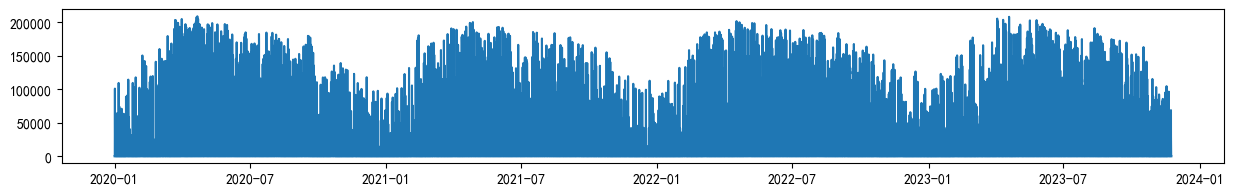

In [116]:
plt.figure(figsize=(15, 2))
plt.plot(train_series.index,train_series)

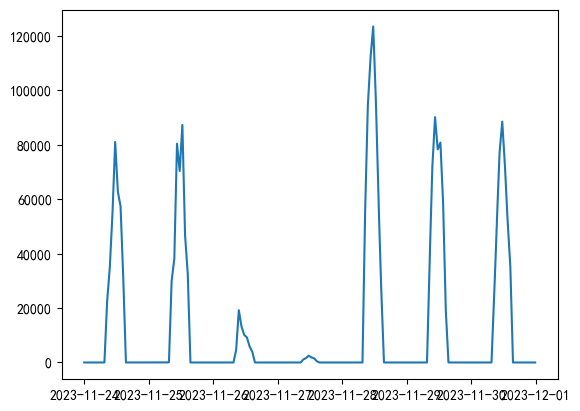

In [117]:
plt.plot(test_series.index,test_series)

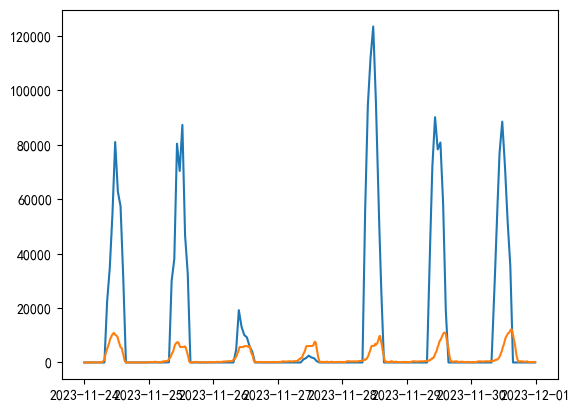

In [118]:
plt.plot(test_series.index,test_series)
plt.plot(pred_series.index,pred_series)
plt.show()

## 加入周期特征

In [120]:
import numpy as np
import pandas as pd
import lightgbm as lgb

def create_features(series, window=96):
    """
    滚动窗口构造X，y，同时加上周期性特征。
    - 基础特征：前window个点的功率
    - 周期特征：小时（sin, cos），日（sin, cos），月（sin, cos）
    """
    X, y = [], []
    values = series.values
    times = series.index

    for i in range(window, len(series)):
        power_features = values[i-window:i]

        timestamp = times[i]
        hour = timestamp.hour + timestamp.minute / 60
        day_of_year = timestamp.dayofyear
        month = timestamp.month

        cyclical_features = [
            np.sin(2 * np.pi * hour / 24), np.cos(2 * np.pi * hour / 24),
            np.sin(2 * np.pi * day_of_year / 365), np.cos(2 * np.pi * day_of_year / 365),
            np.sin(2 * np.pi * month / 12), np.cos(2 * np.pi * month / 12),
        ]

        X.append(np.concatenate([power_features, cyclical_features]))
        y.append(values[i])
    return np.array(X), np.array(y)

# 设置窗口
window_size = 96  # 用过去 96 个 15 分钟点（24小时）

# 构建训练数据
X_train, y_train = create_features(train_series, window=window_size)

# LightGBM 训练
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'seed': 42,
}
model = lgb.train(params, train_data, num_boost_round=200)

# 滚动预测
history = train_series.values[-window_size:].tolist()
time_history = train_series.index[-window_size:].tolist()
predictions = []

for ts in test_series.index:
    hour = ts.hour + ts.minute / 60
    day_of_year = ts.dayofyear
    month = ts.month
    cyclical_features = [
        np.sin(2 * np.pi * hour / 24), np.cos(2 * np.pi * hour / 24),
        np.sin(2 * np.pi * day_of_year / 365), np.cos(2 * np.pi * day_of_year / 365),
        np.sin(2 * np.pi * month / 12), np.cos(2 * np.pi * month / 12),
    ]
    x_input = np.array(history[-window_size:] + cyclical_features).reshape(1, -1)
    y_pred = model.predict(x_input)[0]
    predictions.append(y_pred)
    history.append(y_pred)
    time_history.append(ts)

# 输出预测值
pred_series = pd.Series(predictions, index=test_series.index)


In [135]:
pred_series_noisy = pred_series.copy()

# 找到大于0的索引
positive_mask = pred_series > 0

# 计算噪声（以预测值的标准差为基准）
noise_scale = 0.05  # 可调节
noise = np.random.normal(loc=0, scale=noise_scale * pred_series[positive_mask].std(), size=positive_mask.sum())

# 添加噪声，仅作用于大于0的位置
pred_series_noisy[positive_mask] += noise

# 保障功率非负
pred_series_noisy[pred_series_noisy < 0] = 0

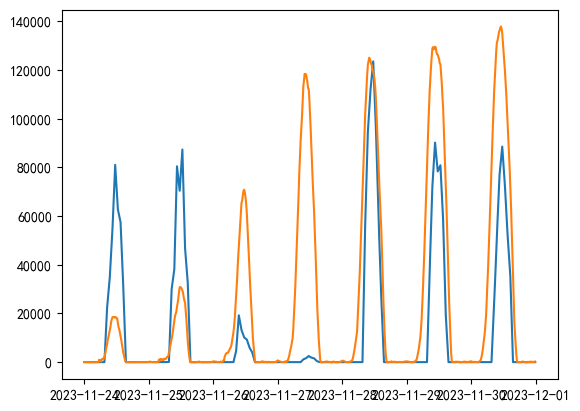

In [139]:
plt.plot(test_series.index,test_series)
plt.plot(pred_series.index,pred_series)
plt.show()

## 指标

In [123]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr


In [124]:
def evaluate_forecast(y_true: pd.Series, y_pred: pd.Series, p_cap = 244.8 * 1000) -> dict:
    """计算RMSE, MAE, ME, 相关系数, 准确率和合格率"""
    y_true = y_true.values
    y_pred = y_pred.values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    me = np.mean(y_pred - y_true)
    
    # 相关系数（如果都为0会异常）
    try:
        corr, _ = pearsonr(y_true, y_pred)
    except:
        corr = np.nan

    accuracy = (1 - rmse / p_cap) * 100  # 推荐归一化后再计算准确率
    compliance = np.mean((np.abs(y_pred - y_true) / p_cap) <= 0.25)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'ME': me,
        'Correlation': corr,
        'Accuracy (%)': accuracy,
        'Compliance Rate': compliance
    }

In [125]:
evaluate_forecast(test_series,pred_series)

{'RMSE': 31712.237569117624,
 'MAE': 17485.10316432493,
 'ME': 11543.810309343271,
 'Correlation': 0.6821750435384805,
 'Accuracy (%)': 87.04565458777876,
 'Compliance Rate': 0.9226190476190477}

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# 填补缺失值
train_series = train_series.interpolate(limit_direction='both').fillna(0)
test_series = test_series.interpolate(limit_direction='both').fillna(0)

# 模型参数（保守起步）
order = (1, 0, 1)          # 非季节性部分
seasonal_order = (1, 1, 1, 96)  # 日周期为 96 个点（15分钟 * 24小时）

# 拟合模型
model = SARIMAX(train_series,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# 预测
forecast = results.forecast(steps=len(test_series))
forecast.index = test_series.index